DEEP LEARNING <br>
GANS <br>

In [1]:
# ! rm -rf image_folder

In [2]:
!nvidia-smi

Sat Nov 26 09:11:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import time
import glob
import imageio
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras  import layers, Input
from tensorflow.keras.initializers import RandomNormal
from IPython import display

seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

print('tf version: ', tf.__version__)
print('keras version: ', keras.__version__)

gpu = tf.config.list_physical_devices('GPU')
print('gpu: ', gpu)

tf version:  2.9.2
keras version:  2.9.0
gpu:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
img_rows = 28 # width
img_cols = 28 # height
channels = 1  # color channels
img_shape = (img_rows, img_cols, channels) 
z_dim = 128
num_classes = 10

In [5]:
def get_data(buffer_size, batch_size):

    (images, labels), (_, _) = keras.datasets.mnist.load_data()
    images = images.reshape(images.shape[0], 28, 28, 1).astype('float32')
    images = (images - 127.5) / 127.5
    # normalize to range [-1, 1]

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

Define G and D

In [6]:
def get_G(z_dim):
    
    model = keras.Sequential([
        Input(z_dim),
        layers.Dense(7*7*256, use_bias=False),
        layers.BatchNormalization(),
        layers.Reshape((7,7,256)),

        layers.Conv2D(
            128,
            4,
            padding='same',
            use_bias=False,
            kernel_initializer=RandomNormal(0, 0.02),
        ),

        layers.BatchNormalization(),
        layers.ReLU(),

        layers.UpSampling2D(),
        layers.Conv2D(
            64,
            1,
            padding='same',
            use_bias=False,
            kernel_initializer=RandomNormal(0, 0.02),
        ),

        layers.BatchNormalization(),
        layers.ReLU(),

        layers.UpSampling2D(),
        layers.Conv2D(
            1,
            4,
            padding='same',
            use_bias=False,
            kernel_initializer=RandomNormal(0, 0.02),
        ),

        layers.Activation('tanh'),
        
        ],name='content-g')


    z = Input(shape=(z_dim), name='noise_input')
    label = Input(shape=(1,), dtype='int32', name='label_input')

    label_embedding = layers.Embedding(num_classes, z_dim, input_length=1)(label)
    label_embedding = layers.Flatten()(label_embedding)

    joint_representation = layers.Multiply()([z, label_embedding])
    outputs = model(joint_representation)

    return keras.Model(inputs=[z,label], outputs=outputs, name='cG')

In [7]:
def get_D(img_shape):
    
    concat_shape = (img_shape[0], img_shape[1], img_shape[2] + 1) # 28, 28, 2

    model = keras.Sequential([
        Input(concat_shape),
        layers.Conv2D(
            64,
            4,
            2,
            padding='same',
            kernel_initializer=RandomNormal(0, 0.02)
        ),

        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2D(
            128,
            4,
            2,
            padding='same',
            kernel_initializer=RandomNormal(0, 0.02)
        ),

        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Flatten(),
        layers.Dense(1),

    ], name='content-d')

    img = Input(shape=img_shape, name='img_input')
    label = Input(shape=(1,), dtype='int32', name='label')

    label_embedding = layers.Embedding(num_classes, np.prod(img_shape), input_length=1)(label)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape(img_shape)(label_embedding)

    joint_representation = layers.Concatenate(axis=-1)([img, label_embedding])
    outputs = model(joint_representation)

    return keras.Model(inputs=[img,label], outputs=outputs, name='cD')

In [8]:
cond_G = get_G(z_dim)
cond_G.summary()

Model: "cG"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 128)       1280        ['label_input[0][0]']            
                                                                                                  
 noise_input (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 128)          0           ['embedding[0][0]']              
                                                                                                 

In [9]:
cond_D = get_D(img_shape)
cond_D.summary()

Model: "cD"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 label (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 784)       7840        ['label[0][0]']                  
                                                                                                  
 flatten_2 (Flatten)            (None, 784)          0           ['embedding_1[0][0]']            
                                                                                                  
 img_input (InputLayer)         [(None, 28, 28, 1)]  0           []                               
                                                                                                 

Configure optimizer and loss

In [10]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

# TTUR -> use different lr in D and G
g_optimizer = keras.optimizers.Adam(learning_rate=3e-4, beta_1=0.5, beta_2=0.9)
d_optimizer = keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5, beta_2=0.9)

# mean tracker
d_loss_track = keras.metrics.Mean(name='d_loss')
g_loss_track = keras.metrics.Mean(name='g_loss')

In [11]:
# use soft labels for d_loss
def discriminator_loss(real_output, fake_output):

    real_labels = tf.ones_like(real_output)
    real_labels = real_labels + 0.05 * tf.random.uniform(tf.shape(real_output))

    fake_labels = tf.zeros_like(fake_output)
    fake_labels = fake_labels + 0.05 * tf.random.uniform(tf.shape(fake_output))

    real_loss = cross_entropy(real_labels, real_output)
    fake_loss = cross_entropy(fake_labels, fake_output)

    return (real_loss + fake_loss) / 2

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
@tf.function
def train_step(images, labels, noise_dim=z_dim):
    
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, noise_dim])
    
    # train D
    with tf.GradientTape() as d_tape:

      fake_images = cond_G([noise, labels], training = True)
      real_output = cond_D([images, labels], training = True)
      fake_output = cond_D([fake_images, labels], training = True)

      d_loss = discriminator_loss(real_output, fake_output)
    
    d_grad = d_tape.gradient(d_loss, cond_D.trainable_variables)
    d_optimizer.apply_gradients(zip(d_grad, cond_D.trainable_variables))

    # train G
    noise = tf.random.normal([batch_size, noise_dim])
    with tf.GradientTape() as g_tape:

      fake_images = cond_G([noise, labels], training = True)
      fake_output = cond_D([fake_images, labels], training = True)

      g_loss = generator_loss(fake_output)

    g_grad = g_tape.gradient(g_loss, cond_G.trainable_variables)
    g_optimizer.apply_gradients(zip(g_grad, cond_G.trainable_variables))  

    d_loss_track.update_state(d_loss)
    g_loss_track.update_state(g_loss)

In [13]:
def generate_and_save_images(model, epoch, inputs, labels):

    predictions = model([inputs, labels], training=False)
    predictions *= 127.5 
    predictions += 127.5

    fig = plt.figure(figsize=(10, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 5, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.title(labels[i].numpy()[0])

    file_name = 'image_at_epoch_{:04d}.png'.format(epoch)
    path = os.path.join('image_folder', file_name)
    plt.savefig(path)
    plt.show()

11490434/11490434 [==============================] - 0s 0us/step
iamges shape:  (256, 28, 28, 1)
labels shape:  (256,)
labels:  [4 5 7 5 3 6 9 1 3 9 6 7 5 1 4 9]



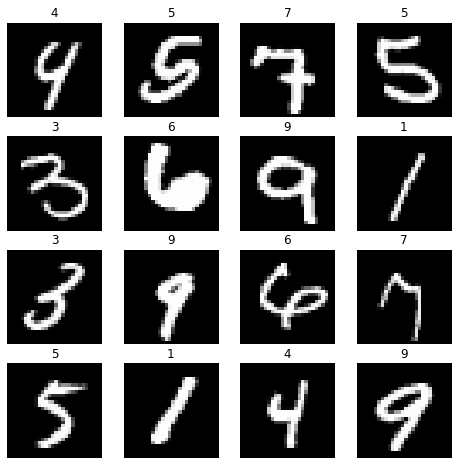

In [14]:
buffer_size = 30000
batch_size = 256
test_datagen = get_data(buffer_size, batch_size)

for images, labels in test_datagen:
    print('iamges shape: ', images.shape)
    print('labels shape: ', labels.shape)
    print('labels: ', labels[:16].numpy())
    print()

    fig = plt.figure(figsize=(8, 8))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.axis('off')
        plt.title(labels[i].numpy())
    break

In [15]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_optimizer,
                                 discriminator_optimizer=d_optimizer,
                                 generator=cond_G,
                                 discriminator=cond_D)

In [16]:
num_examples = 10
test_inputs = tf.random.normal((num_examples, z_dim))
test_labels = tf.constant(range(10))
test_labels = tf.reshape(test_labels, shape=(10, 1))

In [17]:
os.makedirs('image_folder', exist_ok=True)
time.sleep(3)

Training loop

DONE..



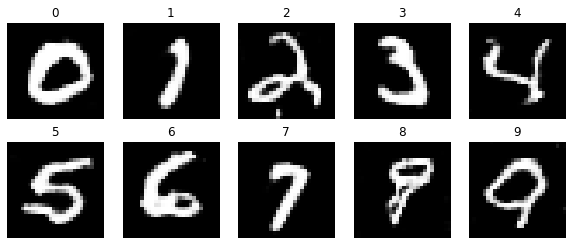

In [22]:
EPOCHS = 30
D_loss_list = []
G_loss_list = []

buffer_size = 30000
batch_size = 256
print('loading data...')
dataset = get_data(buffer_size, batch_size)

for epoch in range(EPOCHS):
    print(f'stating epoch {epoch + 1}')
    start = time.time()

    for images, labels in dataset:
        train_step(images, labels)

    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    display.clear_output(wait=True)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    # avg loss at end of epoch
    d_loss = d_loss_track.result().numpy()
    g_loss = g_loss_track.result().numpy()
    print(f'D loss : {d_loss}, G loss : {g_loss}')
    print()
    generate_and_save_images(cond_G, epoch + 1, test_inputs, test_labels)
    print()

    D_loss_list.append(d_loss)
    G_loss_list.append(g_loss)

# Generate after the final epoch
display.clear_output(wait=True)
print("DONE..")
print()
generate_and_save_images(cond_G, epoch + 1, test_inputs, test_labels)

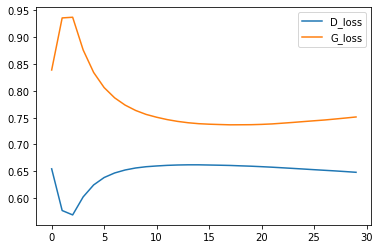

In [23]:
loss_dict = {'D_loss': D_loss_list, 'G_loss': G_loss_list}
loss_df = pd.DataFrame(loss_dict)
loss_df.plot()
plt.show()

In [ ]:
# restore model and optimizer
# checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Play with G here

In [24]:
def play_with_G(label, model=cond_G):

    noise = tf.random.normal((1, z_dim))
    label = tf.constant([[label]])

    gen_img = cond_G([noise, label], training=False).numpy()
    gen_img = gen_img.reshape((28, 28))
    plt.imshow(gen_img * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    plt.show()

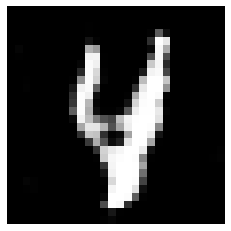

In [30]:
play_with_G(4)

ของติดไม้ติดมือ

In [31]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image_folder/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)